/Users/burakkizilok/Projects/OzelKonular/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Eğitim: 3747 | Doğrulama: 937 | Test: 1172


/Users/burakkizilok/Projects/OzelKonular/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8016 - loss: 0.3628
Epoch 1: val_loss improved from inf to 0.11654, saving model to Model/best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 657s 5s/step - accuracy: 0.8025 - loss: 0.3616 - val_accuracy: 0.9584 - val_loss: 0.1165 - learning_rate: 1.0000e-04
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9698 - loss: 0.0891
Epoch 2: val_loss did not improve from 0.11654
118/118 ━━━━━━━━━━━━━━━━━━━━ 631s 5s/step - accuracy: 0.9697 - loss: 0.0892 - val_accuracy: 0.9434 - val_loss: 0.1534 - learning_rate: 1.0000e-04
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9702 - loss: 0.0870
Epoch 3: val_loss improved from 0.11654 to 0.07313, saving model to Model/best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 701s 6s/step - accuracy: 0.9702 - loss: 0.0870 - val_accuracy: 0.9691 - val_loss: 0.0731 - learning_rate: 1.0000e-04
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9854 - loss: 0.04

<Figure size 600x500 with 0 Axes>

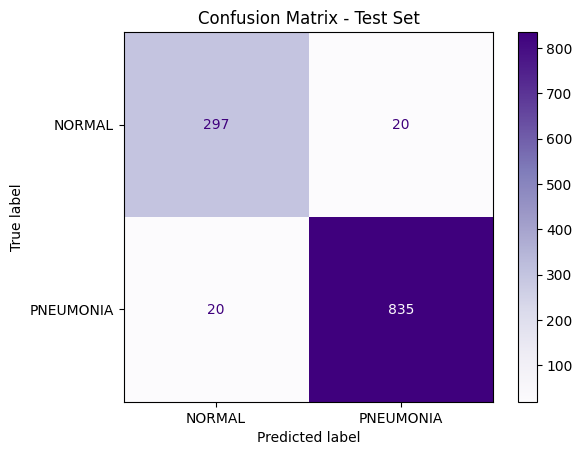

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import random
from collections import Counter


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# =============== Veri kökü ve etiket haritası ===============
data_dir = "dataset"  
target_map = {"NORMAL": 0, "PNEUMONIA": 1}

# =============== Görselleri topla ===============
data = []
for label_name, label_val in target_map.items():
    class_dir = os.path.join(data_dir, label_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            fpath = os.path.join(class_dir, fname)
            data.append((fpath, label_val))

df = pd.DataFrame(data, columns=["filepath", "label"])
assert len(df) > 0, "Görüntü bulunamadı. Klasör yollarını kontrol et."

# =============== Train/Val/Test böl ===============
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["label"], random_state=SEED
)

print(f"Eğitim: {len(train_df)} | Doğrulama: {len(val_df)} | Test: {len(test_df)}")

# =============== Data Generator ===============
class StrokeDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, target_size=(224, 224),
                 shuffle=True, augment=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.target_size = target_size  # (W, H)
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _read_image(self, path):
        img = cv2.imread(path)  
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        img = cv2.merge([gray, gray, gray])

        # Resize
        img = cv2.resize(img, self.target_size, interpolation=cv2.INTER_AREA)

        # Augmentasyon 
        if self.augment:
            if random.random() > 0.5:
                img = cv2.flip(img, 1)
            if random.random() > 0.7:
                h, w = self.target_size[1], self.target_size[0]
                angle = random.randint(-15, 15)
                M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
                img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR,
                                     borderMode=cv2.BORDER_REFLECT_101)

        # float32 ve InceptionResNetV2 preprocess ([-1,1])
        img = img.astype('float32')
        img = preprocess_input(img)  # 0-255 RGB → [-1,1]

        return img

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indices]

        batch_images, batch_labels = [], []
        for _, row in batch_df.iterrows():
            img = self._read_image(row['filepath'])
            if img is None:
                continue
            batch_images.append(img)
            batch_labels.append(float(row['label']))

        if len(batch_images) == 0:
            fallback_idx = random.randint(0, len(self.dataframe) - 1)
            img = self._read_image(self.dataframe.loc[fallback_idx, 'filepath'])
            if img is not None:
                batch_images.append(img)
                batch_labels.append(float(self.dataframe.loc[fallback_idx, 'label']))

        X = np.stack(batch_images, axis=0)
        y = np.array(batch_labels, dtype=np.float32)
        return X, y

# Generator'lar
train_gen = StrokeDataGenerator(train_df, augment=True)
val_gen   = StrokeDataGenerator(val_df, augment=False, shuffle=False)
test_gen  = StrokeDataGenerator(test_df, augment=False, shuffle=False)

# =============== Model ===============
def build_inceptionresnetv2(input_shape=(224, 224, 3), lr=1e-4, dropout_rate=0.5):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_inceptionresnetv2()

# =============== Kayıt ve Callback'ler ===============
model_dir = "Model"
os.makedirs(model_dir, exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=os.path.join(model_dir, "best_model.keras"),
                    monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                      min_lr=1e-6, verbose=1)
]
# =============== Eğitim ===============
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

# =============== Test & Rapor ===============
y_true, y_pred = [], []
for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    preds = model.predict(X_batch, verbose=0)
    preds = (preds > 0.5).astype(int)
    y_true.extend(y_batch)
    y_pred.extend(preds.squeeze())

y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Purples", values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()
